In [1]:
# Standard libraries
import xarray as xr
import numpy as np
import pandas as pd
# import os
# from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
import iris
from iris.pandas import as_cubes
import sys
import math
import os
import glob

from datetime import datetime
from cartopy.util import add_cyclic_point
import gc
import imageio.v2
from IPython import display
# import netCDF4
from global_land_mask import globe
# # Import tobac itself:
import tobac
from merge_split import merge_split_MEST, merge_split_detector
# Disable a few warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

In [2]:
%%time
path = '/glade/u/home/noteng/work/research/data/'
file = 'march13-march14.nc'
data = xr.open_dataset(path+file)
data = data.sel(time=slice('2020-03-13T04:00:00.000000000', '2020-03-14T05:00:00.000000000'))
data.close()

CPU times: user 46.2 ms, sys: 21 ms, total: 67.3 ms
Wall time: 76.1 ms


In [3]:
# equivalent_reflectivity_factor = data['equivalent_reflectivity_factor'][:,450:580,256:771] #Based on longitude and latitude of Andoya and Norwegian Sea
equivalent_reflectivity_factor = data['equivalent_reflectivity_factor'][:,250:650,450:850] #Based on longitude and latitude of Andoya and Norwegian Sea
# equivalent_reflectivity_factor = data['equivalent_reflectivity_factor'][:,330:580,660:780] #### hdm1 and hdm2
# equivalent_reflectivity_factor = data['equivalent_reflectivity_factor']
equivalent_reflectivity_factor

<xarray.DataArray 'equivalent_reflectivity_factor' (time: 301, Yc: 400, Xc: 400)>
[48160000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2020-03-13T04:00:00 ... 2020-03-14T05:00:00
  * Xc       (Xc) float32 -8.3e+04 -8.2e+04 -8.1e+04 ... 3.15e+05 3.16e+05
  * Yc       (Yc) float32 -2.06e+06 -2.061e+06 ... -2.458e+06 -2.459e+06
    lon      (Yc, Xc) float32 ...
    lat      (Yc, Xc) float32 ...
Attributes:
    standard_name:  equivalent_reflectivity_factor
    long_name:      Radar Reflectivity
    units:          dBZ
    grid_mapping:   projection_lambert

In [4]:
# load Mask_ERF_files
Mask_ERF = iris.load('../saved-files/threshold-all/Mask_ERF_iris-all-all.nc')[0]
Mask_ERF

<iris 'Cube' of segmentation_mask / (1) (time: 301; -- : 400; -- : 400)>

In [5]:
tracks = pd.read_csv('../saved-files/threshold-all/cells-allkm-KAZR-thres-all-all.csv')
tracks

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance,mean dBZ,max dBZ,area($km^2$),cloud_id
0,0,453,121.000000,324.705104,2,0,5,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.181000e+06,241705.104259,70.248601,16.323888,5,0 days 00:00:00,125.680339,13.245867,34.567482,132.310998,1
1,0,456,135.877490,273.231217,7,0,6,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.195877e+06,190231.216954,70.159887,14.951233,6,0 days 00:00:00,116.846876,13.245867,34.567482,331.269006,2
2,0,471,168.000000,286.000000,1,0,10,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.228000e+06,203000.000000,69.858376,15.206022,10,0 days 00:00:00,81.936672,13.245867,34.567482,65.658469,3
3,0,481,203.473824,247.478730,4,0,13,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.263474e+06,164478.729588,69.565035,14.156179,13,0 days 00:00:00,76.275220,13.245867,34.567482,327.324894,4
4,0,482,204.000000,286.176995,2,0,14,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.264000e+06,203176.994856,69.531731,15.128128,14,0 days 00:00:00,48.610059,13.245867,34.567482,171.124975,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55639,300,555,178.000000,358.012383,2,20,66372,2020-03-14 05:00:00,2020-03-14 05:00:00,-2.238000e+06,275012.383147,69.698076,17.005561,15276,0 days 00:10:00,80.687235,14.702386,40.106802,208.928144,7117
55640,300,575,285.000000,350.000000,1,20,66383,2020-03-14 05:00:00,2020-03-14 05:00:00,-2.345000e+06,267000.000000,68.738228,16.495682,15277,0 days 00:10:00,55.407771,14.702386,40.106802,214.931734,7118
55641,300,576,286.727785,374.604901,6,20,66384,2020-03-14 05:00:00,2020-03-14 05:00:00,-2.346728e+06,291604.900654,68.696045,17.083278,15278,0 days 00:10:00,74.819683,14.702386,40.106802,494.549355,7119
55642,300,539,295.648140,392.416781,10,15,66361,2020-03-14 05:00:00,2020-03-14 05:00:00,-2.355648e+06,309416.781206,68.594721,17.483020,15279,0 days 00:10:00,94.427981,14.702386,40.106802,115.430654,7120


In [6]:
# sorting out values based on cell_id(provided by TOBAC by default) and cloud_id(manually created)
tracks = tracks.sort_values(by=['cell', 'cloud_id']).reset_index(drop=True)
tracks

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance,mean dBZ,max dBZ,area($km^2$),cloud_id
0,0,453,121.000000,324.705104,2,0,5,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.181000e+06,241705.104259,70.248601,16.323888,5,0 days 00:00:00,125.680339,13.245867,34.567482,132.310998,1
1,1,581,124.000000,327.838844,2,5,374,2020-03-13 04:05:00,2020-03-13 04:05:00,-2.184000e+06,244838.843751,70.218311,16.396476,5,0 days 00:05:00,122.977127,12.974534,35.577388,158.174980,1
2,2,716,127.000000,331.000000,1,10,780,2020-03-13 04:10:00,2020-03-13 04:10:00,-2.187000e+06,248000.000000,70.187965,16.469553,5,0 days 00:10:00,120.373766,12.780750,34.063904,272.576605,1
3,3,578,128.746166,333.673351,6,5,1063,2020-03-13 04:15:00,2020-03-13 04:15:00,-2.188746e+06,250673.350542,70.169425,16.533521,5,0 days 00:15:00,119.040644,12.708913,36.584485,247.709497,1
4,4,611,133.000000,334.000000,1,5,1406,2020-03-13 04:20:00,2020-03-13 04:20:00,-2.193000e+06,251000.000000,70.130630,16.529381,5,0 days 00:20:00,114.859159,12.845599,38.092506,94.508120,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55639,299,476,293.326516,390.199380,15,15,66254,2020-03-14 04:55:00,2020-03-14 04:55:00,-2.353327e+06,307199.379687,68.618348,17.437243,15279,0 days 00:05:00,91.303475,15.240493,41.116443,117.421341,7120
55640,300,539,295.648140,392.416781,10,15,66361,2020-03-14 05:00:00,2020-03-14 05:00:00,-2.355648e+06,309416.781206,68.594721,17.483020,15279,0 days 00:10:00,94.427981,14.702386,40.106802,115.430654,7120
55641,298,555,260.000000,211.000000,1,25,66190,2020-03-14 04:50:00,2020-03-14 04:50:00,-2.320000e+06,128000.000000,69.072189,13.157945,15281,0 days 00:00:00,100.574806,15.301029,39.603226,100.492397,7121
55642,299,531,260.153314,213.000000,3,25,66288,2020-03-14 04:55:00,2020-03-14 04:55:00,-2.320153e+06,130000.000000,69.069779,13.206974,15281,0 days 00:05:00,98.661443,15.240493,41.116443,106.461253,7121


## _Concentrate now on cell-evolution_ 

In [8]:
# Getting the unique cells
# unique_cell_ids = np.unique(tracks['cell'].values)
# unique_cell_ids
# cells closer to AMF1-site
unique_cell_ids = np.array([3853, 4510, 5392, 5247,
                            5957, 6069, 6261,
                            5754, 6964, 6384, 6879, 7798,
                            8368, 8759, 9298, 9090, 9538, 
                            9851, 9652, 10277, 9269, 10329,
                            10763, 10993, 11796, 11983, 12522,
                            12794, 13475, 13527, 13845, 14450,
                            14460, 14816, 15099, 15099, 15099])
print(unique_cell_ids)

[ 3853  4510  5392  5247  5957  6069  6261  5754  6964  6384  6879  7798
  8368  8759  9298  9090  9538  9851  9652 10277  9269 10329 10763 10993
 11796 11983 12522 12794 13475 13527 13845 14450 14460 14816 15099 15099
 15099]


In [9]:
len(unique_cell_ids)

37

In [10]:
# # Original array with duplicate values
# original_array = np.array([3853, 4510, 5392, 5247, 5957, 6069, 6261,
#                            5754, 6964, 6384, 6879, 7798, 8368, 8759,
#                            9298, 9090, 9538, 9851, 9652, 10277, 9269,
#                            10329, 10763, 10993, 11796, 11983, 12522,
#                            12794, 13475, 13527, 13845, 14450, 14460,
#                            14816, 15099])

# # Obtain unique elements along with their indices and inverse
# unique_values, unique_indices, inverse_indices = np.unique(original_array,
#                                                           return_index=True,
#                                                           return_inverse=True)



# # Reconstruct the original array using inverse_indices
# unique_values1 = unique_values[inverse_indices]

# print("Reconstructed array:", unique_values1)

In [11]:
%%time
# all masked cell in iris cube
masked_tracked_cell = []
for i, unique_value in enumerate(unique_cell_ids):
    # get masked cell based on cell id
    get_mask_cell = tobac.utils.mask_cell(mask=Mask_ERF, cell=unique_value, track=tracks, masked=False) 
    masked_tracked_cell.append(get_mask_cell)

CPU times: user 94.9 ms, sys: 4 µs, total: 94.9 ms
Wall time: 112 ms


In [12]:
%%time
# Convert the segmented/mask cells from iris cube to xrray
masked_values_to_xarray = []
for i, items in enumerate(masked_tracked_cell):
    mask_convert_xr = xr.DataArray.from_iris(masked_tracked_cell[i]) # convert iris cube to xarray data array
    masked_values_to_xarray.append(mask_convert_xr) # append the results to list
    # print(mask_convert_xr)

CPU times: user 412 ms, sys: 106 ms, total: 518 ms
Wall time: 523 ms


In [13]:
cells_closer_to_AMF1_statistics = []
for i, v in enumerate(unique_cell_ids):
    cell_closer_to_AMF1 = tracks[tracks['cell'] == unique_cell_ids[i]]
    # print(cell_closer_to_AMF1)
    cells_closer_to_AMF1_statistics.append(cell_closer_to_AMF1)

In [14]:
start_time = cells_closer_to_AMF1_statistics[36]['timestr'].values[0]
end_time =  cells_closer_to_AMF1_statistics[36]['timestr'].values[-1]
tobac_cell_id = cells_closer_to_AMF1_statistics[34]['cell'].values[0]

tobac_cell_id

15099

In [15]:
for i in range(0, len(cells_closer_to_AMF1_statistics)):
    start_time = cells_closer_to_AMF1_statistics[i]['timestr'].values[0]
    end_time =  cells_closer_to_AMF1_statistics[i]['timestr'].values[-1]
    time_cell = cells_closer_to_AMF1_statistics[i]['time_cell'].values[-1]
    count_time = cells_closer_to_AMF1_statistics[i]['time_cell'].values.size
    print(f"{i+1} , {start_time} , {end_time} , {time_cell} , {count_time}")

1 , 2020-03-13 07:45:00 , 2020-03-13 08:50:00 , 0 days 01:05:00 , 14
2 , 2020-03-13 08:35:00 , 2020-03-13 09:50:00 , 0 days 01:15:00 , 16
3 , 2020-03-13 09:45:00 , 2020-03-13 11:00:00 , 0 days 01:15:00 , 16
4 , 2020-03-13 09:35:00 , 2020-03-13 10:35:00 , 0 days 01:00:00 , 13
5 , 2020-03-13 10:35:00 , 2020-03-13 10:45:00 , 0 days 00:10:00 , 3
6 , 2020-03-13 10:45:00 , 2020-03-13 12:30:00 , 0 days 01:45:00 , 22
7 , 2020-03-13 11:00:00 , 2020-03-13 12:20:00 , 0 days 01:20:00 , 17
8 , 2020-03-13 10:20:00 , 2020-03-13 11:55:00 , 0 days 01:35:00 , 20
9 , 2020-03-13 11:55:00 , 2020-03-13 12:10:00 , 0 days 00:15:00 , 4
10 , 2020-03-13 11:10:00 , 2020-03-13 12:50:00 , 0 days 01:40:00 , 21
11 , 2020-03-13 11:50:00 , 2020-03-13 12:55:00 , 0 days 01:05:00 , 14
12 , 2020-03-13 13:05:00 , 2020-03-13 14:20:00 , 0 days 01:15:00 , 16
13 , 2020-03-13 14:05:00 , 2020-03-13 14:15:00 , 0 days 00:10:00 , 3
14 , 2020-03-13 14:45:00 , 2020-03-13 16:05:00 , 0 days 01:20:00 , 17
15 , 2020-03-13 15:45:00 , 2020-

In [16]:
data = []
for i in range(0, len(cells_closer_to_AMF1_statistics)):
    # get tobac ID
    tobac_cell_id = cells_closer_to_AMF1_statistics[i]['cell'].values[0]
    # get cells start-time
    start_time = cells_closer_to_AMF1_statistics[i]['timestr'].values[0]
    # get cells end-time
    end_time =  cells_closer_to_AMF1_statistics[i]['timestr'].values[-1]
    # get cells total time
    time_cell = cells_closer_to_AMF1_statistics[i]['time_cell'].values[-1]
    # get cells total time count
    count_time = cells_closer_to_AMF1_statistics[i]['time_cell'].values.size
    data.append([i+1, tobac_cell_id, start_time, end_time, time_cell, count_time])

# Define the column names
columns = ["ID", "tobac-ID", "start_time", "end_time", "cell_time", "cell_time_count"]

# Create the DataFrame
df = pd.DataFrame(data, columns=columns)

# Convert the 'start_time' and 'end_time' columns to datetime objects
df["start_time"] = pd.to_datetime(df["start_time"])
df["end_time"] = pd.to_datetime(df["end_time"])

In [17]:
df

,ID,tobac-ID,start_time,end_time,cell_time,cell_time_count
0,1,3853,2020-03-13 07:45:00,2020-03-13 08:50:00,0 days 01:05:00,14
1,2,4510,2020-03-13 08:35:00,2020-03-13 09:50:00,0 days 01:15:00,16
2,3,5392,2020-03-13 09:45:00,2020-03-13 11:00:00,0 days 01:15:00,16
3,4,5247,2020-03-13 09:35:00,2020-03-13 10:35:00,0 days 01:00:00,13
4,5,5957,2020-03-13 10:35:00,2020-03-13 10:45:00,0 days 00:10:00,3
5,6,6069,2020-03-13 10:45:00,2020-03-13 12:30:00,0 days 01:45:00,22
6,7,6261,2020-03-13 11:00:00,2020-03-13 12:20:00,0 days 01:20:00,17
7,8,5754,2020-03-13 10:20:00,2020-03-13 11:55:00,0 days 01:35:00,20
8,9,6964,2020-03-13 11:55:00,2020-03-13 12:10:00,0 days 00:15:00,4
9,10,6384,2020-03-13 11:10:00,2020-03-13 12:50:00,0 days 01:40:00,21


Text(0, 0.5, 'cell_time_count')

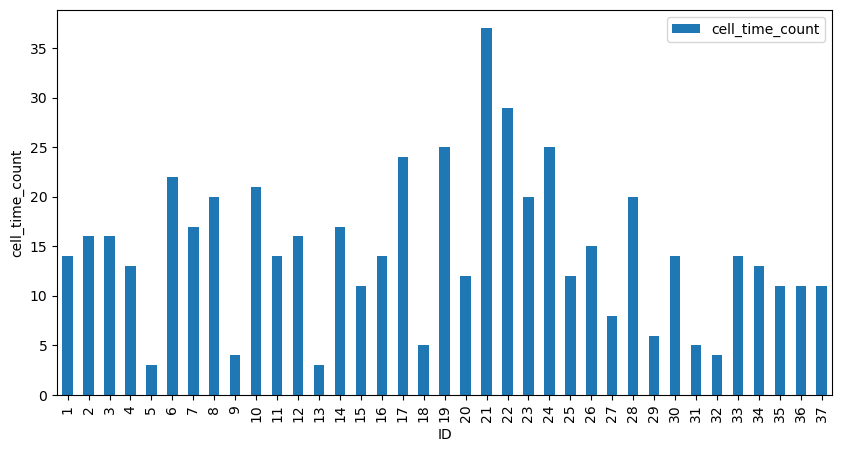

In [18]:
df.plot(x='ID', y='cell_time_count', kind='bar', figsize=(10, 5))
plt.xlabel('ID')
plt.ylabel('cell_time_count')

Text(0, 0.5, 'cell time count')

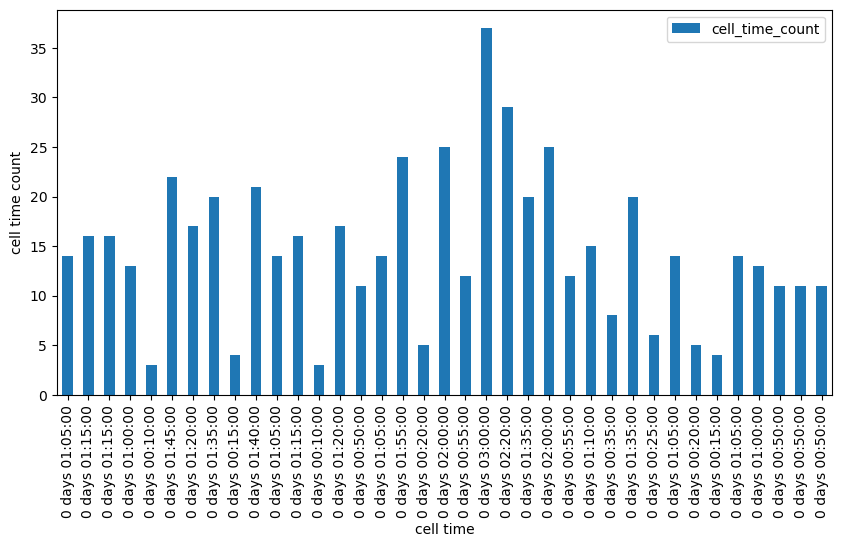

In [19]:
# Plotting the line chart
# df.plot(x='ID', y='cell_time', kind='bar', figsize=(10, 5))
df.plot(x='cell_time', y='cell_time_count', kind='bar', figsize=(10, 5))

# Set the labels for x and y axis
plt.xlabel('cell time')
plt.ylabel('cell time count')

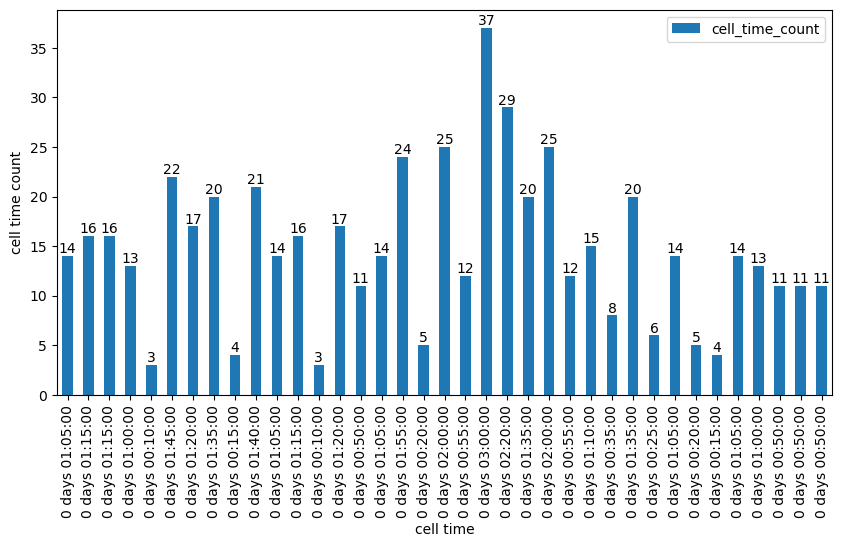

In [20]:
# Plotting the bar chart
ax = df.plot(x='cell_time', y='cell_time_count', kind='bar', figsize=(10, 5))

# Set the labels for x and y axis
plt.xlabel('cell time')
plt.ylabel('cell time count')

# Annotate each bar with the corresponding cell ID
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f"{height}", (x + width / 2, y + height), ha='center', va='bottom')

# Show the plot
plt.show()


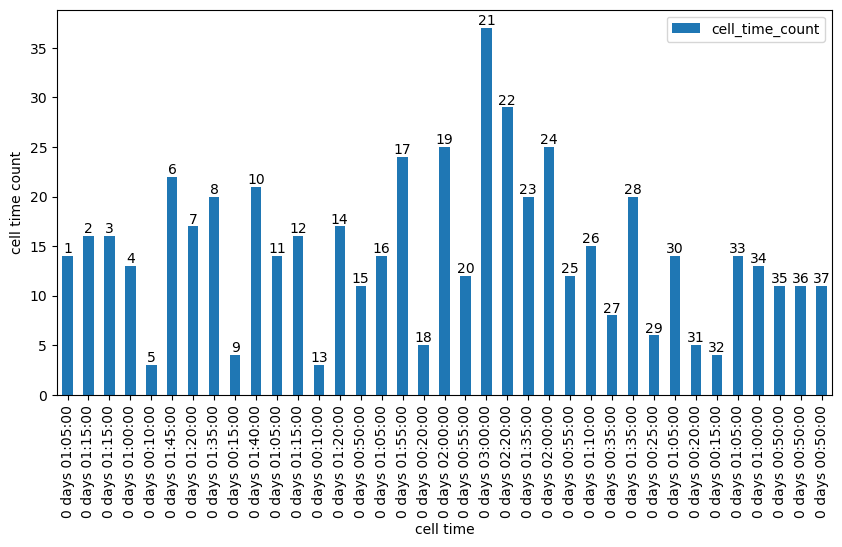

In [21]:
# Plotting the bar chart
ax = df.plot(x='cell_time', y='cell_time_count', kind='bar', figsize=(10, 5))

# Set the labels for x and y axis
plt.xlabel('cell time')
plt.ylabel('cell time count')

# Annotate each bar with the corresponding cell ID
for p, cell_id in zip(ax.patches, df['ID']):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f"{cell_id}", (x + width / 2, y + height), ha='center', va='bottom')

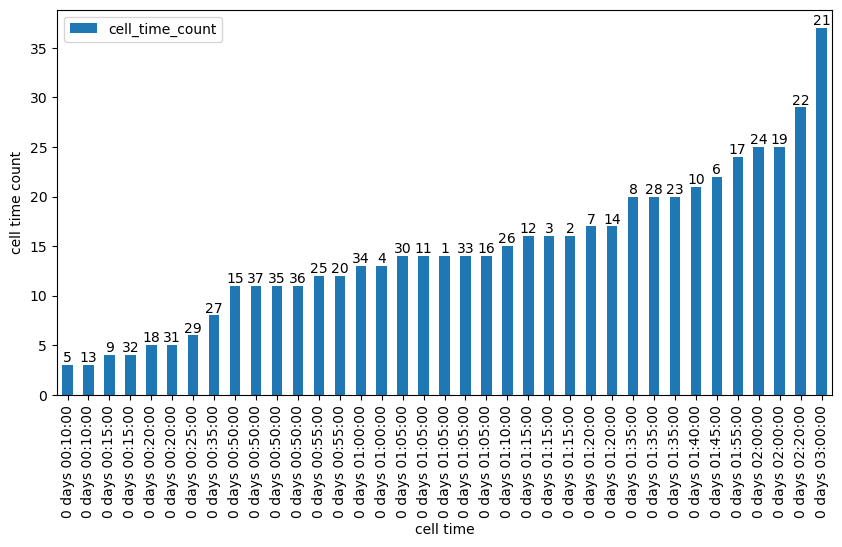

In [22]:
# Sort the DataFrame by 'cell_time_count' in ascending order
df_sorted = df.sort_values(by='cell_time_count')

# Plotting the bar chart
ax = df_sorted.plot(x='cell_time', y='cell_time_count', kind='bar', figsize=(10, 5))

# Set the labels for x and y axis
plt.xlabel('cell time')
plt.ylabel('cell time count')

# Annotate each bar with the corresponding cell ID
for p, cell_id in zip(ax.patches, df_sorted['ID']):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f"{cell_id}", (x + width / 2, y + height), ha='center', va='bottom')

# Add a label to indicate that the numbers are cell IDs
# plt.text(1.02, 0.5, "Cell ID", transform=ax.transAxes, rotation=-90, fontsize=12, va='center')

Text(1.02, 0.5, 'Cell ID')

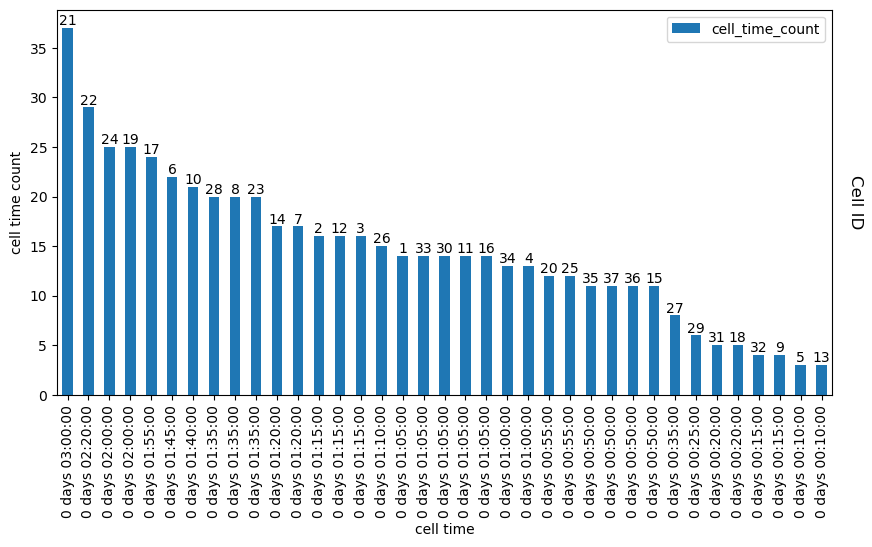

In [23]:
# Sort the DataFrame by 'cell_time_count' in descending order
df_sorted = df.sort_values(by='cell_time_count', ascending=False)

# Plotting the bar chart
ax = df_sorted.plot(x='cell_time', y='cell_time_count', kind='bar', figsize=(10, 5))

# Set the labels for x and y axis
plt.xlabel('cell time')
plt.ylabel('cell time count')

# Annotate each bar with the corresponding cell ID
for p, cell_id in zip(ax.patches, df_sorted['ID']):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f"{cell_id}", (x + width / 2, y + height), ha='center', va='bottom')

# Add a label to indicate that the numbers are cell IDs
plt.text(1.02, 0.5, "Cell ID", transform=ax.transAxes, rotation=-90, fontsize=12, va='center')

In [25]:
# unique_values1 array
unique_values1 = np.array([3853, 4510, 5392, 5247, 5957, 6069, 6261,
                           5754, 6964, 6384, 6879, 7798, 8368, 8759,
                           9298, 9090, 9538, 9851, 9652, 10277, 9269,
                           10329, 10763, 10993, 11796, 11983, 12522,
                           12794, 13475, 13527, 13845, 14450, 14460,
                           14816, 15099])

# Assuming 'cell' is the column containing cell IDs and 'tracks' is the DataFrame
selected_cells = tracks[tracks['cell'].isin(unique_values1)]

# Convert 'cell' column to Categorical with the desired order
selected_cells['cell'] = pd.Categorical(selected_cells['cell'], categories=unique_values1, ordered=True)

# Sort the DataFrame based on the 'cell' column with the custom order
selected_cells_sorted = selected_cells.sort_values(by='cell')

selected_cells_sorted = selected_cells_sorted.drop(labels='cloud_id', axis=1)
selected_cells_sorted['ID'] = selected_cells_sorted.groupby('cell').ngroup() + 1
selected_cells_sorted

/glade/scratch/noteng/ipykernel_263911/2573330102.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_cells['cell'] = pd.Categorical(selected_cells['cell'], categories=unique_values1, ordered=True)


,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance,mean dBZ,max dBZ,area($km^2$),ID
14043,45,1207,218.000000,292.000000,1,25,15185,2020-03-13 07:45:00,2020-03-13 07:45:00,-2.278000e+06,209000.000000,69.399918,15.242049,3853,0 days 00:00:00,33.618718,16.042307,40.109338,43.777214,1
14056,58,1232,249.452017,323.000000,2,20,19155,2020-03-13 08:50:00,2020-03-13 08:50:00,-2.309452e+06,240000.000000,69.087128,15.932925,3853,0 days 01:05:00,11.587548,16.912909,45.646124,191.036419,1
14055,57,1323,248.269003,313.494029,4,25,18896,2020-03-13 08:45:00,2020-03-13 08:45:00,-2.308269e+06,230494.028756,69.106640,15.702412,3853,0 days 01:00:00,3.958735,16.933993,48.166156,314.413227,1
14054,56,1291,246.180927,311.956156,11,25,18581,2020-03-13 08:40:00,2020-03-13 08:40:00,-2.306181e+06,228956.155748,69.126969,15.669709,3853,0 days 00:55:00,1.725708,16.621385,44.135408,266.657803,1
14052,54,1248,241.156969,307.812424,14,25,17975,2020-03-13 08:30:00,2020-03-13 08:30:00,-2.301157e+06,224812.424451,69.176248,15.579826,3853,0 days 00:45:00,5.650811,16.263989,42.624679,587.046232,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55275,291,584,242.000000,308.443904,2,20,65445,2020-03-14 04:15:00,2020-03-14 04:15:00,-2.302000e+06,225443.904202,69.168038,15.593364,15099,0 days 00:05:00,4.645552,15.043664,40.612898,232.828949,35
55274,290,618,241.000000,307.471234,3,20,65340,2020-03-14 04:10:00,2020-03-14 04:10:00,-2.301000e+06,224471.233605,69.177973,15.571789,15099,0 days 00:00:00,6.014945,14.966083,38.596077,210.935241,35
55283,299,506,259.298870,322.524053,7,20,66270,2020-03-14 04:55:00,2020-03-14 04:55:00,-2.319299e+06,239524.053277,68.998285,15.896280,15099,0 days 00:45:00,18.047050,15.240493,41.116443,493.518276,35
55278,294,606,250.000000,313.519008,2,25,65790,2020-03-14 04:30:00,2020-03-14 04:30:00,-2.310000e+06,230519.007625,69.090918,15.698781,15099,0 days 00:20:00,5.671682,15.196207,39.099655,361.184971,35


In [26]:
selected_cells_sorted = selected_cells_sorted.reset_index(drop=True)
selected_cells_sorted

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance,mean dBZ,max dBZ,area($km^2$),ID
0,45,1207,218.000000,292.000000,1,25,15185,2020-03-13 07:45:00,2020-03-13 07:45:00,-2.278000e+06,209000.000000,69.399918,15.242049,3853,0 days 00:00:00,33.618718,16.042307,40.109338,43.777214,1
1,58,1232,249.452017,323.000000,2,20,19155,2020-03-13 08:50:00,2020-03-13 08:50:00,-2.309452e+06,240000.000000,69.087128,15.932925,3853,0 days 01:05:00,11.587548,16.912909,45.646124,191.036419,1
2,57,1323,248.269003,313.494029,4,25,18896,2020-03-13 08:45:00,2020-03-13 08:45:00,-2.308269e+06,230494.028756,69.106640,15.702412,3853,0 days 01:00:00,3.958735,16.933993,48.166156,314.413227,1
3,56,1291,246.180927,311.956156,11,25,18581,2020-03-13 08:40:00,2020-03-13 08:40:00,-2.306181e+06,228956.155748,69.126969,15.669709,3853,0 days 00:55:00,1.725708,16.621385,44.135408,266.657803,1
4,54,1248,241.156969,307.812424,14,25,17975,2020-03-13 08:30:00,2020-03-13 08:30:00,-2.301157e+06,224812.424451,69.176248,15.579826,3853,0 days 00:45:00,5.650811,16.263989,42.624679,587.046232,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,291,584,242.000000,308.443904,2,20,65445,2020-03-14 04:15:00,2020-03-14 04:15:00,-2.302000e+06,225443.904202,69.168038,15.593364,15099,0 days 00:05:00,4.645552,15.043664,40.612898,232.828949,35
516,290,618,241.000000,307.471234,3,20,65340,2020-03-14 04:10:00,2020-03-14 04:10:00,-2.301000e+06,224471.233605,69.177973,15.571789,15099,0 days 00:00:00,6.014945,14.966083,38.596077,210.935241,35
517,299,506,259.298870,322.524053,7,20,66270,2020-03-14 04:55:00,2020-03-14 04:55:00,-2.319299e+06,239524.053277,68.998285,15.896280,15099,0 days 00:45:00,18.047050,15.240493,41.116443,493.518276,35
518,294,606,250.000000,313.519008,2,25,65790,2020-03-14 04:30:00,2020-03-14 04:30:00,-2.310000e+06,230519.007625,69.090918,15.698781,15099,0 days 00:20:00,5.671682,15.196207,39.099655,361.184971,35


In [ ]:
selected_cells_sorted['area($km^2$)']

In [49]:
## group by min, max, area
cell_evolution_March_13 = selected_cells_sorted[['ID', 'cell', 'timestr', 'max dBZ', 'mean dBZ', 'area($km^2$)', 'time_cell']]
b = cell_evolution_March_13[cell_evolution_March_13['ID'] == 21]
b.sort_values(by=['timestr'])

,ID,cell,timestr,max dBZ,mean dBZ,area($km^2$),time_cell
294,21,9269,2020-03-13 15:45:00,40.612898,16.532378,149.211220,0 days 00:00:00
289,21,9269,2020-03-13 15:50:00,45.142555,16.709006,204.915348,0 days 00:05:00
308,21,9269,2020-03-13 15:55:00,43.634195,16.692001,122.354060,0 days 00:10:00
316,21,9269,2020-03-13 16:00:00,42.624679,16.628611,341.197995,0 days 00:15:00
310,21,9269,2020-03-13 16:05:00,41.619997,16.388863,290.473862,0 days 00:20:00
311,21,9269,2020-03-13 16:10:00,43.128252,16.183650,134.295321,0 days 00:25:00
312,21,9269,2020-03-13 16:15:00,41.619997,15.917539,226.807699,0 days 00:30:00
313,21,9269,2020-03-13 16:20:00,40.610380,16.027555,205.916469,0 days 00:35:00
314,21,9269,2020-03-13 16:25:00,39.605794,15.848801,287.490211,0 days 00:40:00
315,21,9269,2020-03-13 16:30:00,41.113953,15.633600,270.584116,0 days 00:45:00


In [102]:
# getting the cell-id(just one)
cell_number = cell1['cell'].values[0]
cell_number

15099

In [103]:
%%time
# cells that merged or splitted
merge_split_detector(TRACK=tracks, dxy=1000, cell=cell_number)

CPU times: user 46.3 s, sys: 215 ms, total: 46.5 s
Wall time: 48.2 s


(       cell_parent_track_id
 cell                       
 15099                6625.0,
 'no merge/split of cell - 1 cell')

In [104]:
# mask individual cell
mask_cell1 = tobac.utils.mask_cell(Mask_ERF, cell_number, tracks)
mask_cell1

<iris 'Cube' of segmentation_mask / (1) (time: 301; -- : 400; -- : 400)>

In [105]:
# converting cell to xarray dataarray from iris cube
convert_cell1 = xr.DataArray.from_iris(mask_cell1)
convert_cell1

<xarray.DataArray 'segmentation_mask' (time: 301, dim_1: 400, dim_2: 400)>
dask.array<filled, shape=(301, 400, 400), dtype=int32, chunksize=(150, 400, 400), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-03-13T04:00:00 ... 2020-03-14T05:00:00
    lat      (dim_1, dim_2) float32 ...
    lon      (dim_1, dim_2) float32 ...
Dimensions without coordinates: dim_1, dim_2
Attributes:
    long_name:    segmentation_mask
    Conventions:  CF-1.7

In [106]:
%%time
for idx, i in enumerate(cell1['frame'].values[:]):
    ## center points and extent of map ###
    latA = 69.141281 #latitude of COMBLE site
    lonA = 15.684166-1 #longitude of COMBLE site -1
    xm, ym = 6,2.75 # extent from center point in lon and lat
    fig, ax = plt.subplots(1,1,figsize=(10, 9), subplot_kw={'projection': ccrs.Orthographic(lonA,latA)})
    extent = (lonA-xm+3.3, lonA+xm-3.7, latA-ym+2, latA+ym-1.5) # define extent map
    ax.set_extent(extent) # set extent of map
    ax.coastlines(resolution='10m', color='black') # plot coastlines with high resolution: 10m
    ax.set_facecolor('white')
    ax.add_feature(cfeature.LAND, linewidth=1.5, alpha=0.5)

    # add grid lines
    gl = ax.gridlines(x_inline=False, alpha=0.3, color='white'); gl.bottom_labels=True; gl.left_labels=True
    gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'rotation': 45}; gl.ylabel_style = {'color': 'black'}

    #change time to moth, day, year, hours and minutes
    dt = masked_values_to_xarray[idx]['time'].dt.strftime('%m-%d-%Y %H:%M').values  ### array
    dt_saved_files_format = masked_values_to_xarray[idx]['time'].dt.strftime('%m-%d-%Y %H_%M').values  ### array
    

#     #     # fill in the place where there is cloud with 1 and place with no cloud to be zero
    cloud = np.asarray(convert_cell1[i], dtype='float')
    # cloud = np.asarray(convert_660[i], dtype='float')
    # print(type(cloud))
    invalid_cloud = np.greater(cloud, 0)
    cloud[invalid_cloud] = 1
    invalid_cloud1 = np.less(cloud,1)
    cloud[invalid_cloud1] = np.nan
    

    cs=ax.pcolormesh(convert_cell1['lon'],
                convert_cell1['lat'], 
                # cloud*equivalent_reflectivity_factor.values[i],
                cloud*equivalent_reflectivity_factor.values[i],
                cmap='jet',
                transform=ccrs.PlateCarree(),
                vmin=-30,
                vmax=30
                )
#     # display each id on cell
    frame=cell1[cell1['frame']==i]
    longi = frame['longitude'].values[0]
    lati = frame['latitude'].values[0]
    cloud_id = frame['cloud_id'].values[0]
    cell_id = frame['cell'].values[0]
    # print(f"cell-id of {cell_id}, now id {cloud_id}")
    
    
    
    # check if area has value of nan
    # if not math.isnan(frame['area($km^2$)'].values[0]):
#     fontdict={'fontweight': 'extra bold'}
#     ax.text(longi, lati+0.1, cell_id, transform=ccrs.PlateCarree(), fontsize=13, color='white', fontdict=fontdict)
    
    fontdict={'fontweight': 'extra bold'}
    ax.text(longi, lati, cell_id, transform=ccrs.PlateCarree(), fontsize=9.7, color='black', fontdict=fontdict)



    ax.plot(lonA+1,latA, color='red', marker='*', markersize = 7.5,transform=ccrs.PlateCarree(), zorder=7) # plot red star at location of Andenes
    ax.set_title(f"Nordic Radar Mosaic: {dt[i]} UTC", fontweight='bold', fontsize=16, pad=11)  # title of figure


    # Add a colorbar axis at the right of the graph
    # cbar_ax = fig.add_axes([0.85, 0.13, 0.047, 0.75]) #lbwh
    cbar_ax = fig.add_axes([0.85, 0.11, 0.047, 0.77]) #lbwh


    cbar=fig.colorbar(cs, cax=cbar_ax, orientation='vertical')
    cbar.set_label("Reflectivity Factor [dBZ]", fontsize = 15)
    
    
    fig.savefig(f'./evolution-cells/cell35//{dt_saved_files_format[i]}.png', dpi=300)
    plt.close()



#     dirr = sorted(os.listdir('./new//'))
#     if f'{dt[i]}.png' in dirr:
#         # print(f'{dt_saved_files_format[i]}.png already exist')
#         pass
#         plt.close()
#     else:
#         fig.savefig(f'./new//{dt_saved_files_format[i]}.png', dpi=100)
#         plt.close()
# print('\U0001f600\U0001f600\U0001f600\U0001f600EXECUTION DONE!!!\U0001f600\U0001f600\U0001f600\U0001f600')
# # gc.collect()

CPU times: user 9.67 s, sys: 640 ms, total: 10.3 s
Wall time: 10.6 s


In [107]:
%%time
# import glob
# Build GIF
imgs = sorted(glob.glob("./evolution-cells/cell35/*.png"))
with imageio.get_writer('./evolution-cells/cell35/cell35.gif', mode='I', duration=0.7) as writer:
    for filename in imgs:
        image = imageio.v2.imread(filename)
        writer.append_data(image)

CPU times: user 7.29 s, sys: 19.3 ms, total: 7.3 s
Wall time: 7.51 s
